In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [ ]:
def example_usage():
    tiny_imagenet = load_dataset('Maysee/tiny-imagenet', split='train')
    print(tiny_imagenet[0])

example_usage()

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x1446D35F0>, 'label': 0}


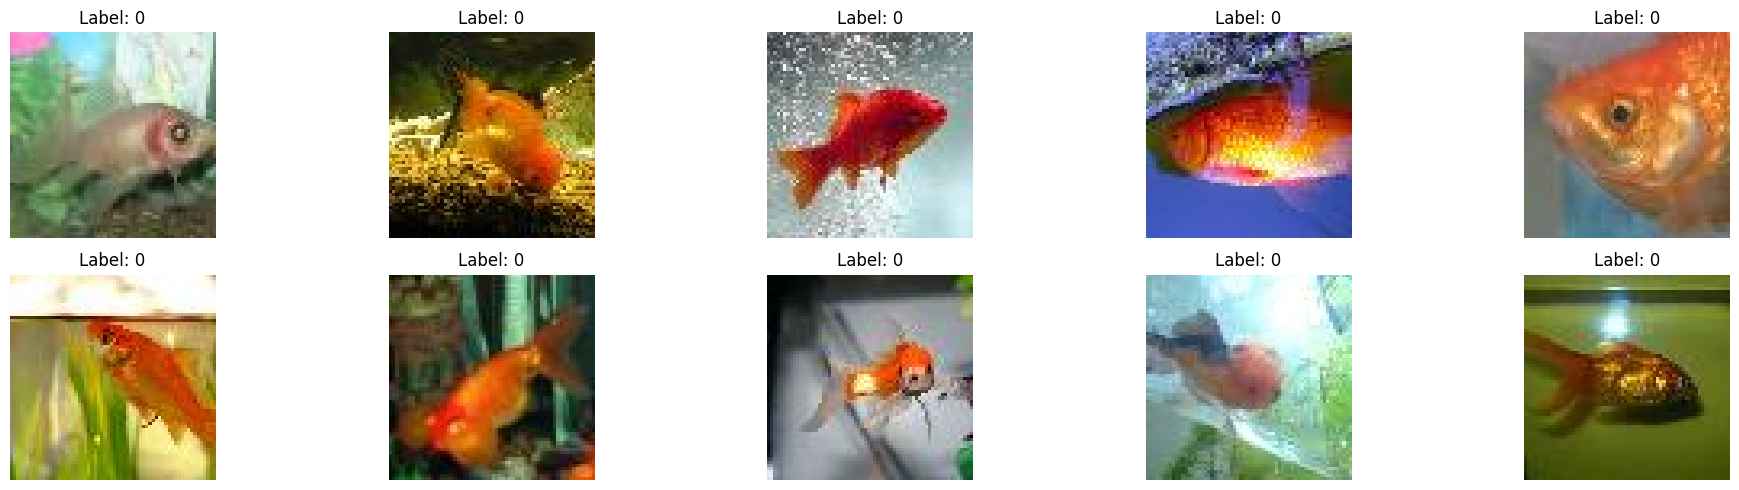

In [3]:
tiny_imagenet = load_dataset('Maysee/tiny-imagenet', split='train')

plt.figure(figsize=(20, 5))
for i in range(10):
    img_pil = tiny_imagenet[i]['image']
    label = tiny_imagenet[i]['label']
    img_np = np.array(img_pil)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_np)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Forward Process

- Gradually adding noise to the image, so that in the reverse process, NN model is used to reverse this process. 

$$
\begin{split}
q(x_t|x_{t-1}) &= \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I) \\
&= \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon \\ 
\epsilon \text{ sampled from } \mathcal{N}(0, 1)
\end{split}
$$

where $\mathcal{N}$ is Normal Dist. . $x_t$ is the image at step $t$. $x_0$ is the original image. $\sqrt{1-\beta_t}$ is the mean of that normal distribution and  $\beta_t I$ is the variance

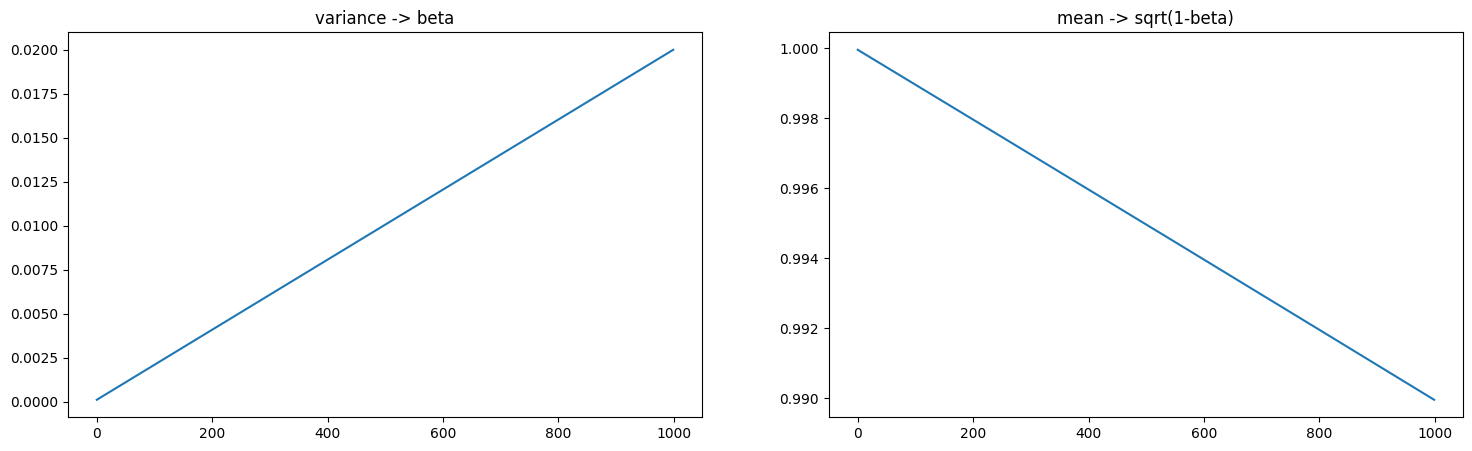

In [4]:
# linear schedule from original paper
beta_start = 0.0001
beta_end = 0.02

v = np.linspace(beta_start, beta_end, 1000)
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(v)
plt.title("variance -> beta")
plt.subplot(1, 2, 2)
plt.plot(np.sqrt(1 - v))
plt.title("mean -> sqrt(1-beta)");

Rather than iteratively applying the forward process to get to $x_t$ from $x_0$, we can do this in single shot by using

$$
\begin{gather}
q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)I) \\
\text{where} \\
\alpha_t = 1 - \beta_t \\
\bar{\alpha}_t = \prod_{s=1}^t \alpha_s
\end{gather}
$$

## Reverse Process

$$
p(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

where $\mu_\theta$ and $\Sigma_\theta$ both are 2 different NNs, one for mean and one for variance. Since the variance is fixed, we dont need to predict it.

This Neural Net will be in the form

$$
p_\theta(x_{t-1}, {t-1}) = \epsilon_\theta
$$

## Loss
$$
|| \epsilon - \epsilon_\theta(x_t, t) ||^2
$$

## Experimentation

In [5]:
x_0 = tiny_imagenet[0]['image']
x_0 = np.array(x_0)
x_0 = (x_0 - 127.5) / 127.5 # -1 to 1
x_0 = torch.tensor(x_0)

### Linear Schedule

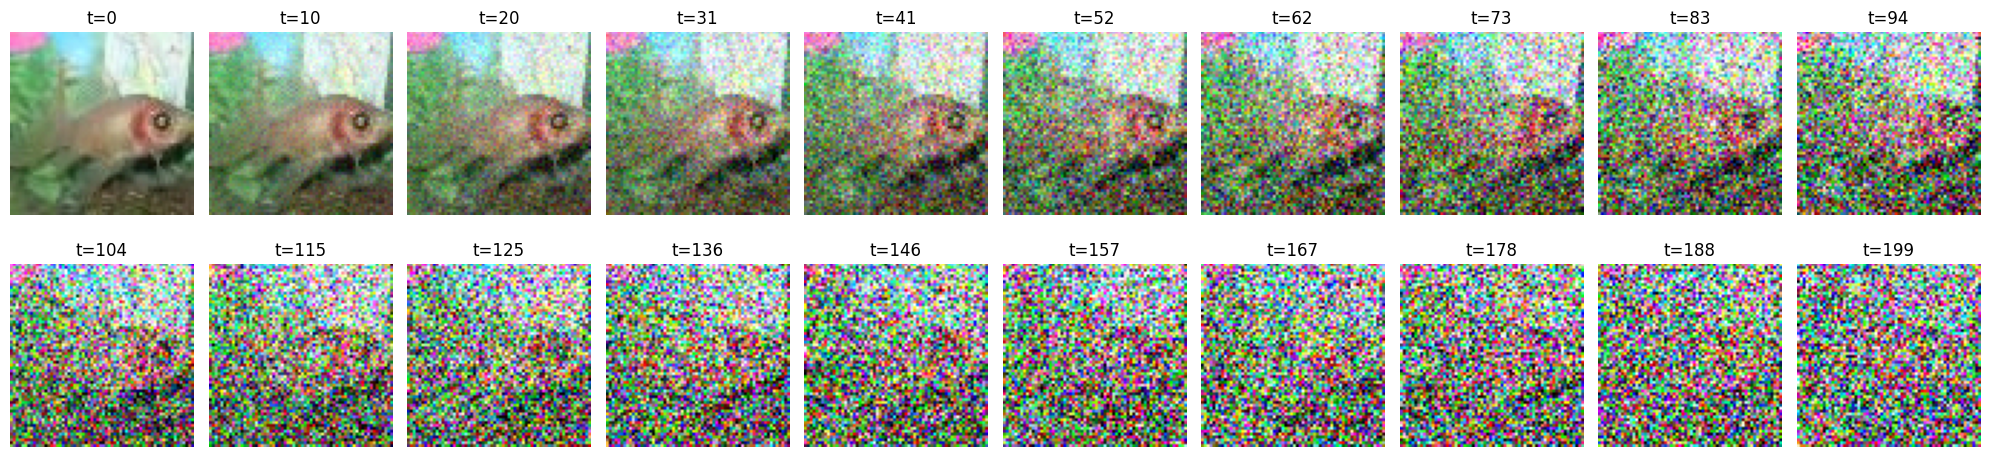

In [9]:
T = 200
beta_start = 0.0001
beta_end = 0.02

lin_betas = torch.linspace(beta_start, beta_end, T)
betas = lin_betas
alphas = 1.0 - betas
bar_alphas = torch.cumprod(alphas, dim=0)
sqrt_bar_alphas = torch.sqrt(bar_alphas)
sqrt_1_minus_bar_alphas = torch.sqrt(1 - bar_alphas)

def forward_diffusion(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_bar_alpha_t = sqrt_bar_alphas[t].reshape(-1, 1, 1) # reshape for broadcasting
    sqrt_1_minus_bar_alpha_t = sqrt_1_minus_bar_alphas[t].reshape(-1, 1, 1)
    return sqrt_bar_alpha_t * x_0 + sqrt_1_minus_bar_alpha_t * noise, noise

num_samples = 20
plt.figure(figsize=(20, 5))
for i, t in enumerate(torch.linspace(0, T-1, num_samples, dtype=torch.int)):
    x_t, _ = forward_diffusion(x_0, t)
    plt.subplot(2, 10, i+1)
    x_t = (x_t + 1) / 2
    plt.imshow(x_t.clamp(0, 1).numpy())
    plt.title(f"t={t.item()}")
    plt.axis("off")
plt.tight_layout()
plt.show(5)

## Cosine Schedule

$$
\begin{gather}
\mathcal{f}(t) = \cos (\frac{\frac{t}{T} + s}{1 + s} \cdot \frac{\pi}{2}) \\
\bar{\alpha}_t = \frac{\mathcal{f}(t)}{\mathcal{f}(0)} \\
\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar\alpha_{t-1}}
\end{gather}
$$

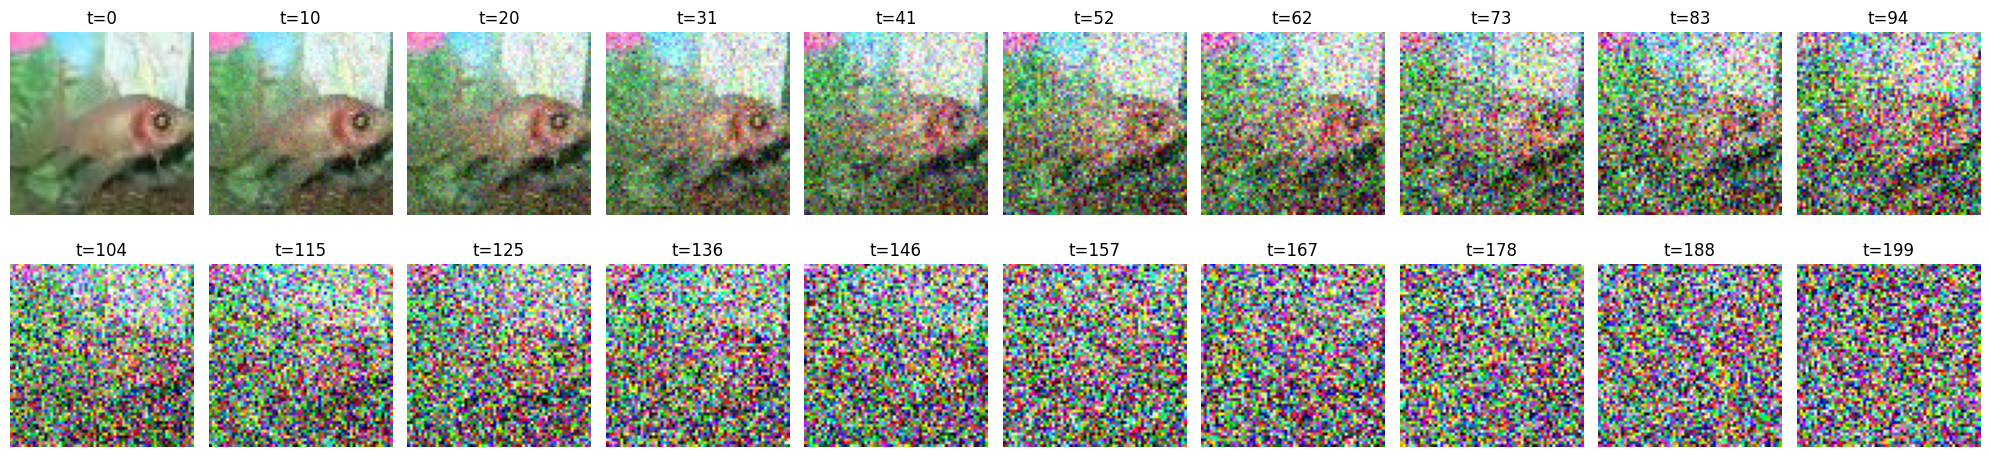

In [10]:
# ----------- beta -------------------
s = 0.008 # from Improved Diffusion paper
x = torch.linspace(0, T, T+1)
f_ts = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
bar_alphas = f_ts / f_ts[0]  # normalize to start at 1
betas = 1 - (bar_alphas[1:] / bar_alphas[:-1])
cosine_betas = torch.clip(betas, 0.0001, 0.9999)
# ---------------------------------------

betas = cosine_betas
# alphas = 1.0 - betas
# bar_alphas = torch.ckmprod(alphas, dim=0)
sqrt_bar_alphas = torch.sqrt(bar_alphas)
sqrt_1_minus_bar_alphas = torch.sqrt(1 - bar_alphas)

def forward_diffusion(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_bar_alpha_t = sqrt_bar_alphas[t].reshape(-1, 1, 1) # reshape for broadcasting
    sqrt_1_minus_bar_alpha_t = sqrt_1_minus_bar_alphas[t].reshape(-1, 1, 1)
    return sqrt_bar_alpha_t * x_0 + sqrt_1_minus_bar_alpha_t * noise, noise

num_samples = 20
plt.figure(figsize=(20, 5))
for i, t in enumerate(torch.linspace(0, T-1, num_samples, dtype=torch.int)):
    x_t, _ = forward_diffusion(x_0, t)
    plt.subplot(2, 10, i+1)
    x_t = (x_t + 1) / 2
    plt.imshow(x_t.clamp(0, 1).numpy())
    plt.title(f"t={t.item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Quadratic

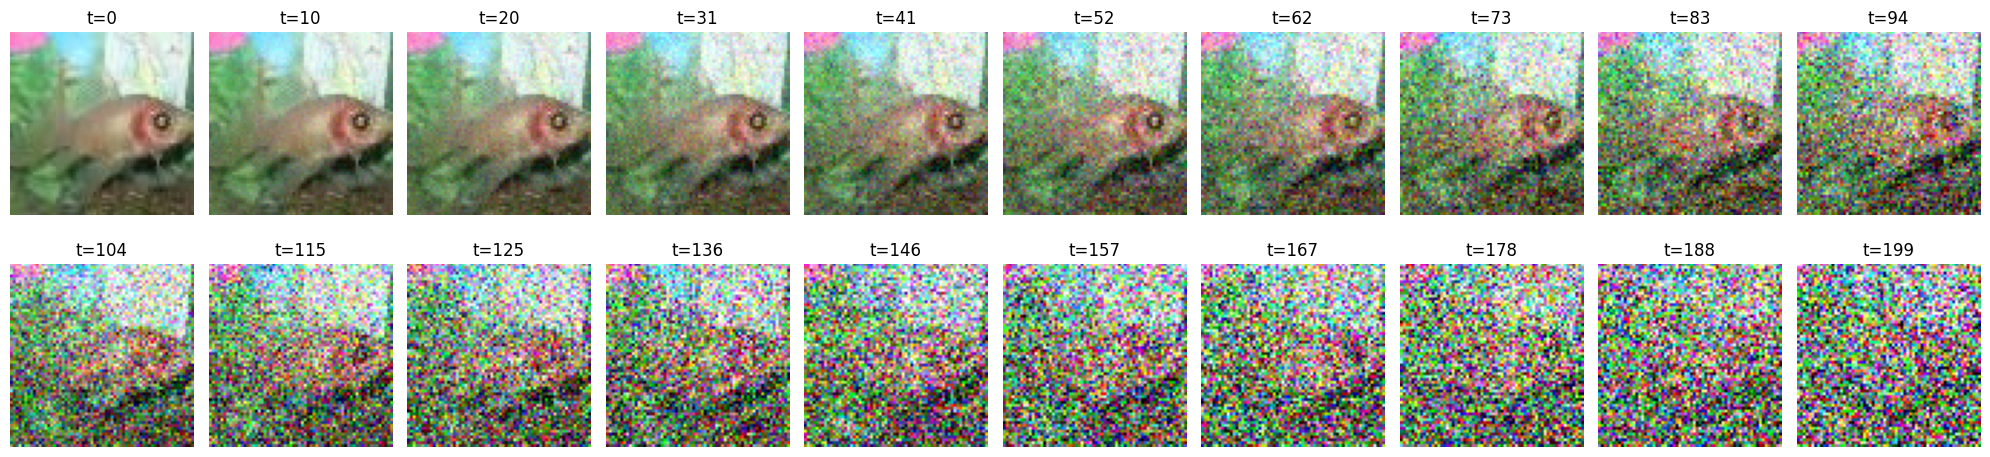

In [14]:
beta_start = 0.0001
beta_end = 0.02
quad_betas = torch.linspace(beta_start**0.5, beta_end**0.5, T) ** 2
betas = quad_betas

alphas = 1.0 - betas
bar_alphas = torch.cumprod(alphas, dim=0)
sqrt_bar_alphas = torch.sqrt(bar_alphas)
sqrt_1_minus_bar_alphas = torch.sqrt(1 - bar_alphas)

def forward_diffusion(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_bar_alpha_t = sqrt_bar_alphas[t].reshape(-1, 1, 1) # reshape for broadcasting
    sqrt_1_minus_bar_alpha_t = sqrt_1_minus_bar_alphas[t].reshape(-1, 1, 1)
    return sqrt_bar_alpha_t * x_0 + sqrt_1_minus_bar_alpha_t * noise, noise

num_samples = 20
plt.figure(figsize=(20, 5))
for i, t in enumerate(torch.linspace(0, T-1, num_samples, dtype=torch.int)):
    x_t, _ = forward_diffusion(x_0, t)
    plt.subplot(2, 10, i+1)
    x_t = (x_t + 1) / 2
    plt.imshow(x_t.clamp(0, 1).numpy())
    plt.title(f"t={t.item()}")
    plt.axis("off")
plt.tight_layout()
plt.show(5)

## Sigmoidal

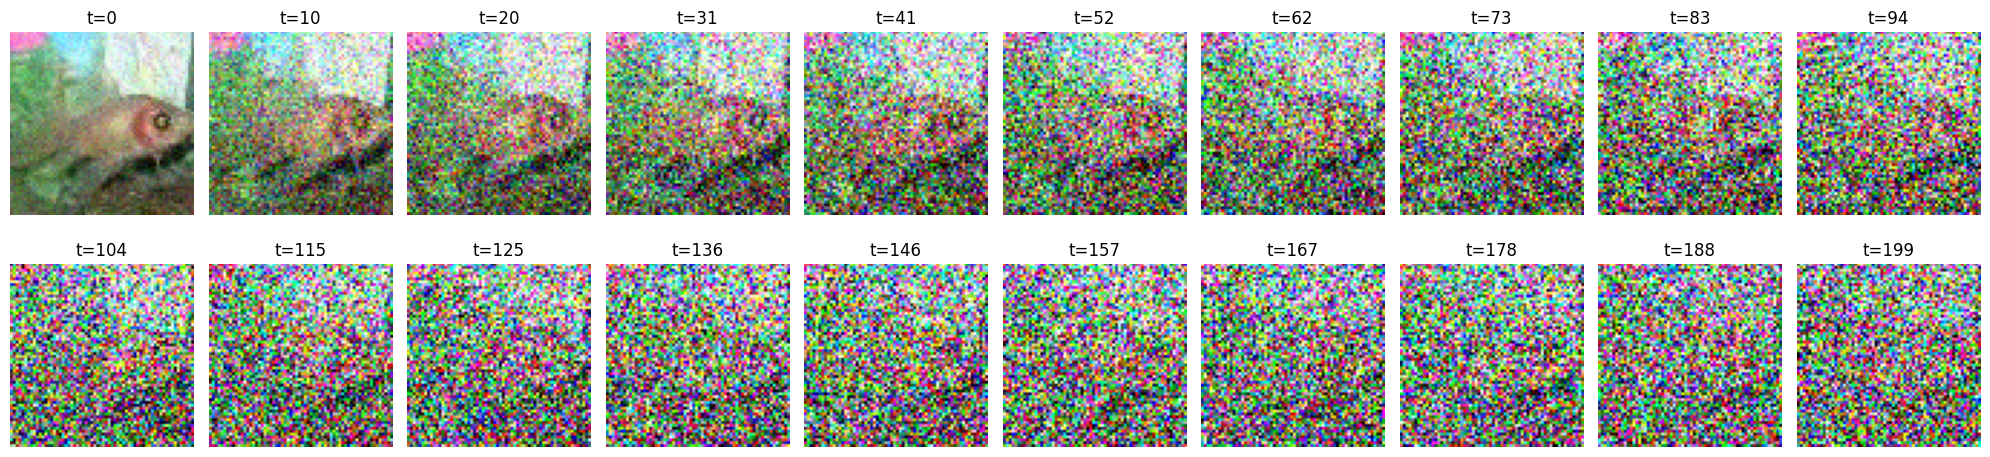

In [15]:
beta_start = 0.0001
beta_end = 0.02
sig = torch.linspace(-6, 6, T)
sigmoid_betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
betas = sigmoid_betas

alphas = 1.0 - betas
bar_alphas = torch.cumprod(alphas, dim=0)
sqrt_bar_alphas = torch.sqrt(bar_alphas)
sqrt_1_minus_bar_alphas = torch.sqrt(1 - bar_alphas)

def forward_diffusion(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_bar_alpha_t = sqrt_bar_alphas[t].reshape(-1, 1, 1) # reshape for broadcasting
    sqrt_1_minus_bar_alpha_t = sqrt_1_minus_bar_alphas[t].reshape(-1, 1, 1)
    return sqrt_bar_alpha_t * x_0 + sqrt_1_minus_bar_alpha_t * noise, noise

num_samples = 20
plt.figure(figsize=(20, 5))
for i, t in enumerate(torch.linspace(0, T-1, num_samples, dtype=torch.int)):
    x_t, _ = forward_diffusion(x_0, t)
    plt.subplot(2, 10, i+1)
    x_t = (x_t + 1) / 2
    plt.imshow(x_t.clamp(0, 1).numpy())
    plt.title(f"t={t.item()}")
    plt.axis("off")
plt.tight_layout()
plt.show(5)

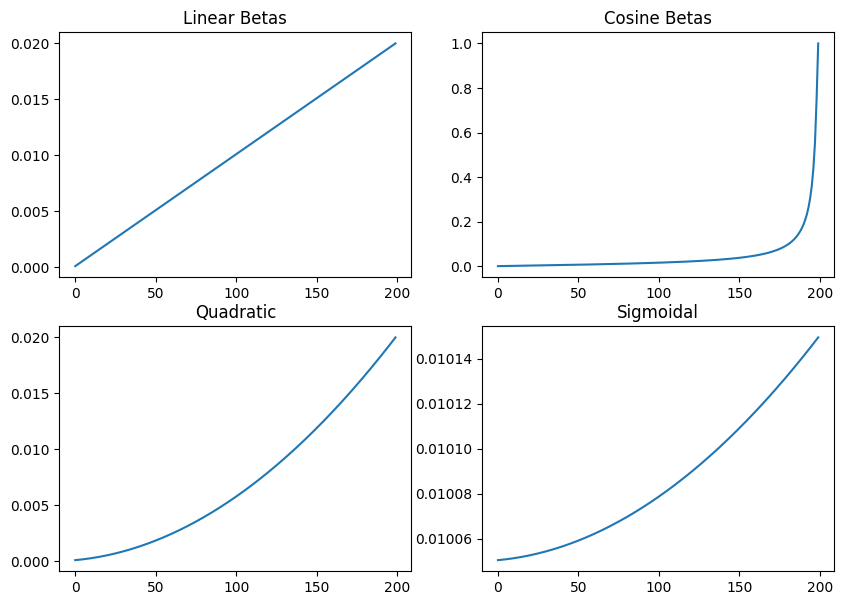

In [18]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.plot(lin_betas)
plt.title("Linear Betas")

plt.subplot(2, 2, 2)
plt.plot(cosine_betas)
plt.title("Cosine Betas")

plt.subplot(2, 2, 3)
plt.plot(quad_betas)
plt.title("Quadratic")

plt.subplot(2, 2, 4)
plt.plot(sigmoid_betas)
plt.title("Sigmoidal");

100%|██████████| 170M/170M [00:38<00:00, 4.42MB/s] 


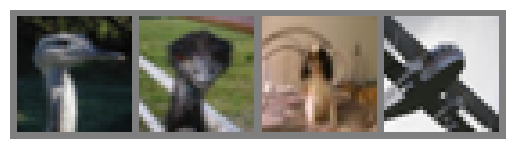

bird  bird  dog   plane


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define a transform to convert the images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Class names in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

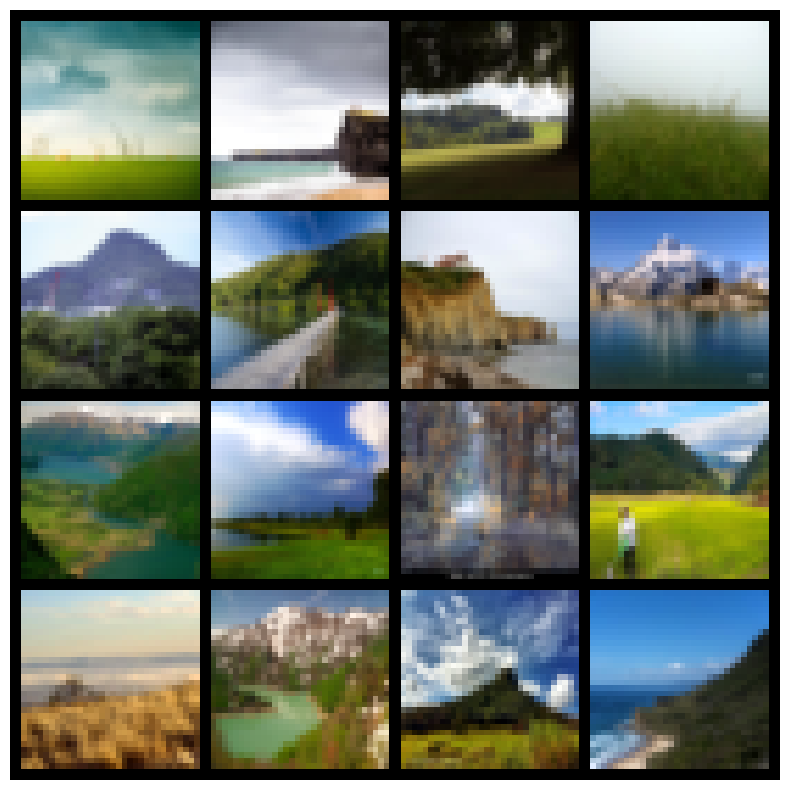

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

def plot_images(dataloader, n_images=16, img_size=32):
    # Get a batch of images
    images, _ = next(iter(dataloader))[:n_images]
    
    # Create a grid of images
    grid = make_grid(images, nrow=4, normalize=True, scale_each=True)
    
    # Convert to numpy and change channel order for matplotlib
    np_grid = grid.numpy().transpose((1, 2, 0))
    
    # Create figure
    plt.figure(figsize=(8, 8))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Modify your DataLoader to return 32x32 images
transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_32 = ImageFolder("/Users/mnjm/workspace/diffusion/dataset-cache/landscapes", transform=transform_32)

dataloader_32 = DataLoader(
    dataset_32,
    batch_size=16,  # Exactly one grid
    shuffle=True
)

# Plot the images
plot_images(dataloader_32)